# *Case Study - Assessment - `Shoes price prediction`*

## *Objective:*
### *`Predicting shoes price for the customers of Zshoes and deploy with the help of flask.`*


## *Problem Statement:*

*Zshoes.com is one of the famous shoe manufacturers of India and has business in almost every country in Asia and Europe. They are one of the best choices of all the athletics and they make the best shoes for running. Due to pandemic, they are facing a loss as Zshoes are a bit expensive. They want to know the correct price of all types of shoes that they are manufacturing so that they won’t face any loss and at the sametime customers also buy the shoes. As a machine learning engineer, we have to build a shoe-price prediction app that can predict the correct shoe price by taking inputs like freight_value,payment_type, etc.*

## *Feature Details:*
- **order_item_id:**      Order id of the shoe.
- **price:**         price of the shoe(Target)
- **freight_value:** freight_value of the shoe
- **payment_sequential:** Sequence of payment
- **payment_type:** types of payment
- **payment_installments:** Installments of payments
- **payment_value:** Value of payment

##### Lets import the required libraries.

In [756]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import statsmodels.api as sm
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBRegressor

##### Lets load the dataset.

In [757]:
df = pd.read_csv('product_data.csv')
df.head()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,1,58.90,13.29,1,1,2,72.19
1,1,239.90,19.93,1,1,3,259.83
2,1,199.00,17.87,1,1,5,216.87
3,1,12.99,12.79,1,1,2,25.78
4,1,199.90,18.14,1,1,3,218.04


In [758]:
df1 = df.copy()

###### Lets separate the dependent and independent variables.

In [759]:
X = df.drop('price',axis=1)
y = df['price']

## *Exploratory Data Analysis.*

##### Lets check the shape of the dataset.

In [760]:
df.shape

(101335, 7)

###### Lets check the datatypes of the attributes.

In [761]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101335 entries, 0 to 101334
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_item_id         101335 non-null  int64  
 1   price                 101335 non-null  float64
 2   freight_value         101335 non-null  float64
 3   payment_sequential    101335 non-null  int64  
 4   payment_type          101335 non-null  int64  
 5   payment_installments  101335 non-null  int64  
 6   payment_value         101335 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 5.4 MB


##### Lets check the descriptive statistics of the attributes.

In [762]:
df.describe()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
count,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000
mean,1.205280,79.818332,16.126716,1.089495,1.352040,2.671703,124.124508
std,0.715244,56.057932,5.943237,0.689100,0.652362,2.524321,124.418064
min,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,35.990000,12.690000,1.000000,1.000000,1.000000,55.550000
50%,1.000000,63.900000,15.470000,1.000000,1.000000,1.000000,95.400000
75%,1.000000,109.900000,18.670000,1.000000,2.000000,3.000000,155.840000
max,21.000000,270.000000,36.000000,26.000000,4.000000,24.000000,3195.730000


###### Lets check the relationship associated between the variables.

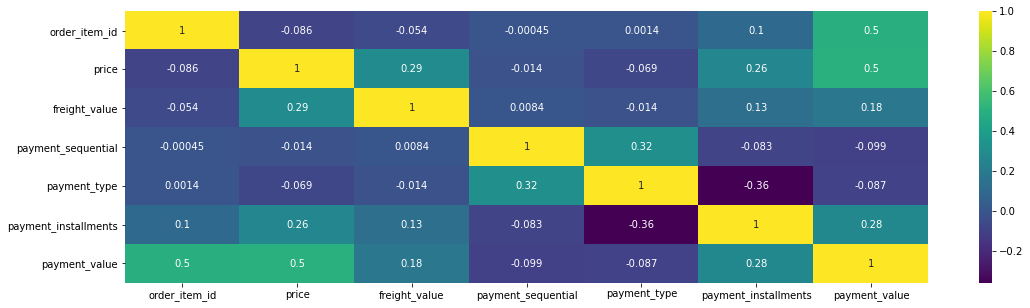

In [763]:
plt.figure(figsize=[18,5])
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.show()

## *`INFERENCE.`*

- **The independent variables payment_value is having the strong positive correlation with the target variable price i.e.,0.5**
- **The independent variables freight_value & payment_installments are having moderate positive correlation with the target variable price.**
- **The independent variables order_item_id,payment_sequential & payment_type are having weak negative correaltion with the target variable price.**
- **The indepenedent variables order_item_id & payment_value, payment_type & payment_sequential, payment_value & payment_installments are correlated with eachother.**

###### Lets check for multicollinearity between the independent variables.

In [764]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vf = [vif(X.values, i) for i in range(X.shape[1])]
pd.DataFrame(vf, index=X.columns, columns=['vif'])

,vif
order_item_id,4.481813
freight_value,5.664716
payment_sequential,3.798302
payment_type,5.222550
payment_installments,2.366340
payment_value,2.974985


## *`INFERENCE.`*

- **Since for all the features the vif value is not greater than 9.**
- **Hence we can say that there is no multicollinearity exists.**

###### Lets check for missing values in the dataset.

In [765]:
df.isnull().sum()

order_item_id           0
price                   0
freight_value           0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

## *`INFERENCE.`*

- **There are no missing values in the dataset.**

###### Lets explore attributes individually.

In [766]:
df[df['payment_value']==0]

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
27701,1,56.99,14.15,3,3,1,0.0
43093,1,94.00,28.04,4,3,1,0.0
55184,1,59.00,15.16,4,3,1,0.0


## *`INFERENCE.`*

- **A we can see there are three records the payment value is zero.**
- **Payment value cannot be zero, So we can impute the payment_value by adding the price and freight value.**

In [771]:
df[df['freight_value']==0]

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
100,1,99.9,0.0,1,2,1,99.9
232,1,69.9,0.0,1,1,1,69.9
443,1,99.9,0.0,1,2,1,99.9
467,1,53.9,0.0,1,1,6,107.8
468,2,53.9,0.0,1,1,6,107.8
...,...,...,...,...,...,...,...
99878,1,53.9,0.0,1,2,1,53.9
100236,1,219.0,0.0,1,1,2,219.0
100377,1,106.9,0.0,1,1,2,106.9
100903,1,195.0,0.0,1,1,5,195.0


## *`INFERENCE.`*

- **Here we can see the there are 389 entries having freight value as zero.**
- **We can say that for these items there is no transportation charges applied.**

In [588]:
df['payment_sequential'].unique()

array([ 1,  2,  5,  6,  4,  3,  7, 11, 10,  8,  9, 12, 13, 14, 15, 17, 22,
       16, 18, 19, 21, 20, 26, 25, 24, 23], dtype=int64)

In [589]:
df['payment_sequential'].value_counts()

1     97070
2      2856
3       563
4       271
5       153
6       103
7        70
8        48
9        39
10       33
11       28
12       21
13       13
14       10
15        9
16        8
17        8
18        8
19        8
20        5
21        5
22        2
25        1
23        1
24        1
26        1
Name: payment_sequential, dtype: int64

- **We can see that there are more number of records when payment_sequential is 1.**

In [590]:
df['payment_type'].unique()     ## The variable payment_type is a categorical variable, we need to change the datatype.

array([1, 2, 3, 4], dtype=int64)

In [591]:
df['payment_type'] = df['payment_type'].astype(object)

In [592]:
df['payment_installments'].unique()

array([ 2,  3,  5,  1,  4,  6,  7, 10,  9,  8, 12, 15, 13, 11, 14, 17,  0,
       18, 16, 21, 24, 23, 20, 22], dtype=int64)

In [593]:
df['payment_installments'].value_counts()

1     53326
2     12475
3     10340
4      6816
5      4943
10     4121
6      3577
8      3400
7      1482
9       573
12      106
15       53
11       24
18       23
24       19
13       16
14       13
16        6
17        6
20        6
21        5
0         3
23        1
22        1
Name: payment_installments, dtype: int64

- **We can see that there are more number of records when payment_installments is 1.**

###### Lets check for Outliers in the dataset.

In [594]:
df_num = df.select_dtypes(include=np.number)
df_num = df_num.drop('price',axis=1)

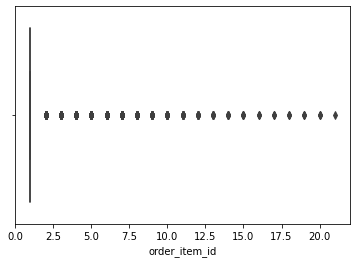

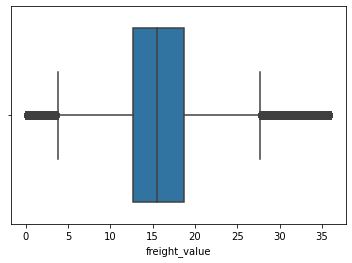

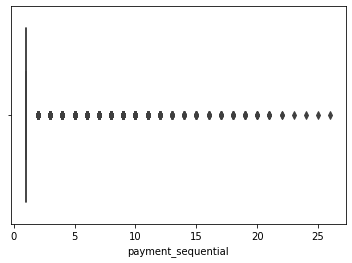

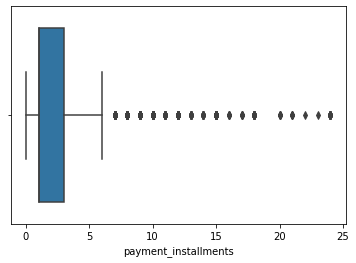

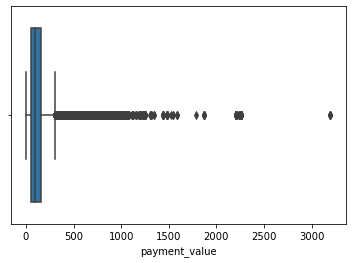

In [595]:
for i in df_num:
    sns.boxplot(df_num[i])
    plt.show()

###### Lets treat the Outliers in the variables payment_value & freight_value by applying transformation techniques.

In [596]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

In [597]:
df.iloc[:,[2,6]] = pt.fit_transform(df.iloc[:,[2,6]])

<AxesSubplot:xlabel='freight_value'>

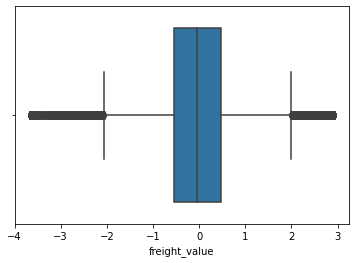

In [598]:
sns.boxplot(df['freight_value'])

<AxesSubplot:xlabel='payment_value'>

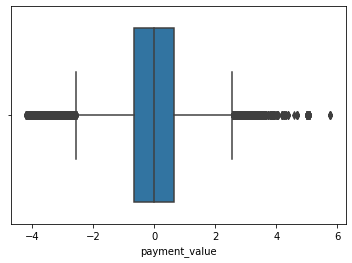

In [599]:
sns.boxplot(df['payment_value'])

In [600]:
df.skew()

order_item_id            7.590041
price                    1.085329
freight_value            0.100175
payment_sequential      15.557169
payment_type             1.946105
payment_installments     1.823110
payment_value            0.059289
dtype: float64

##### lets reduce the skewness of the variables payment_sequential by applying log root transformation technique.*

In [604]:
df['payment_sequential'] = np.log(df['payment_sequential'])
df['order_item_id'] = np.log(df['order_item_id'])

In [605]:
df.skew()

order_item_id           3.075983
price                   1.085329
freight_value           0.100175
payment_sequential      6.805759
payment_type            1.946105
payment_installments    1.823110
payment_value           0.059289
dtype: float64

###### We can see the features having high skewness, their skewness reduced to some extend after applying transformation techniques.

## *Univariate Analysis.*

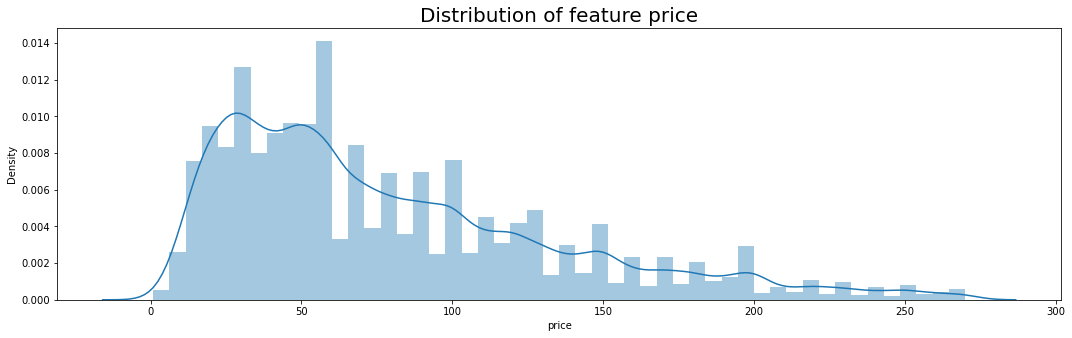

In [607]:
plt.figure(figsize=[18,5])
sns.distplot(df1['price'])
plt.title('Distribution of feature price',fontsize=20)
plt.show()

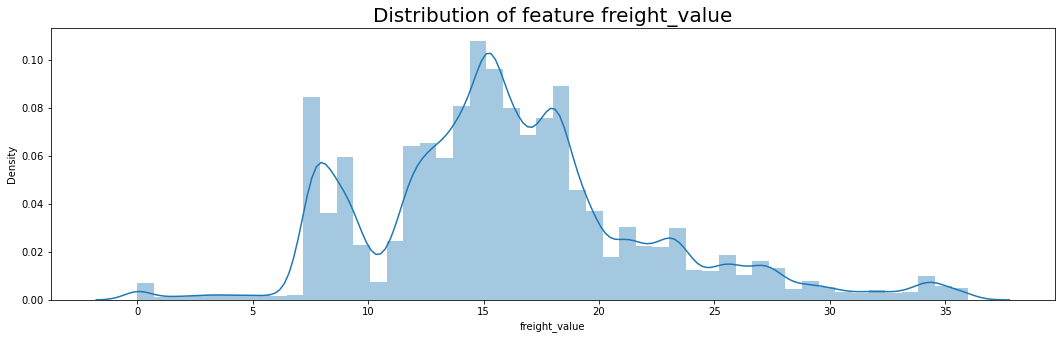

In [608]:
plt.figure(figsize=[18,5])
sns.distplot(df1['freight_value'])
plt.title('Distribution of feature freight_value',fontsize=20)
plt.show()

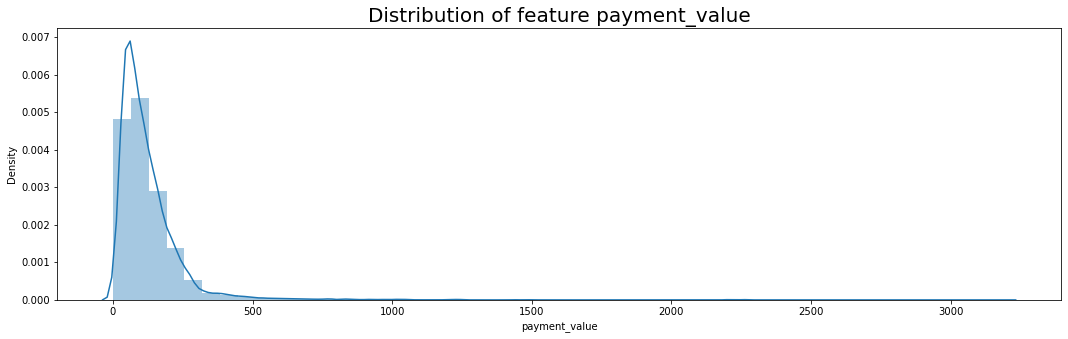

In [609]:
plt.figure(figsize=[18,5])
sns.distplot(df1['payment_value'])
plt.title('Distribution of feature payment_value',fontsize=20)
plt.show()

- **Feature payment_value highly skewed towards right.**

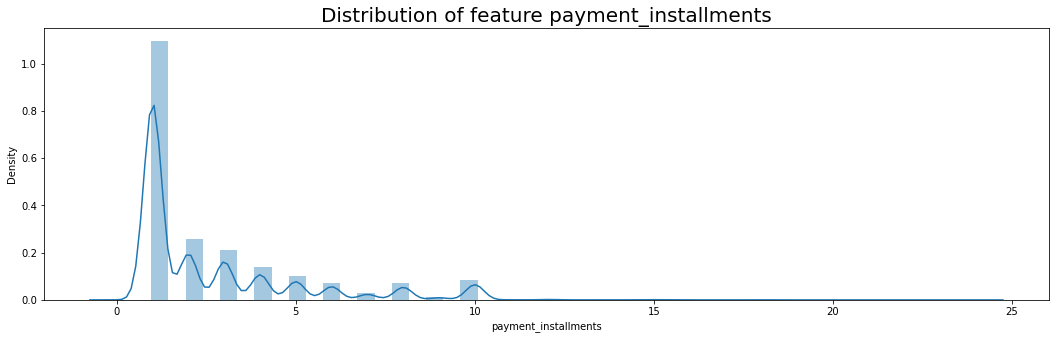

In [610]:
plt.figure(figsize=[18,5])
sns.distplot(df1['payment_installments'])
plt.title('Distribution of feature payment_installments',fontsize=20)
plt.show()

- **The Feature payment_installments is skewed towards right.**

<AxesSubplot:ylabel='payment_type'>

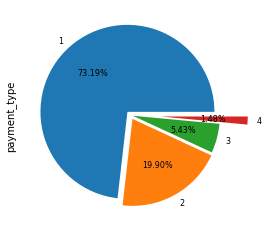

In [611]:
df1['payment_type'].value_counts().plot(kind='pie',autopct='%1.2f%%',explode=[0.05,0.05,0.03,0.35],fontsize=8)

- **We can see from the above piechart the payment_type 1 is having the highest frequency of the records.**
- **The payment_type 4 is having the lowest frequency of the records.**

## *Bivariate Analysis.*

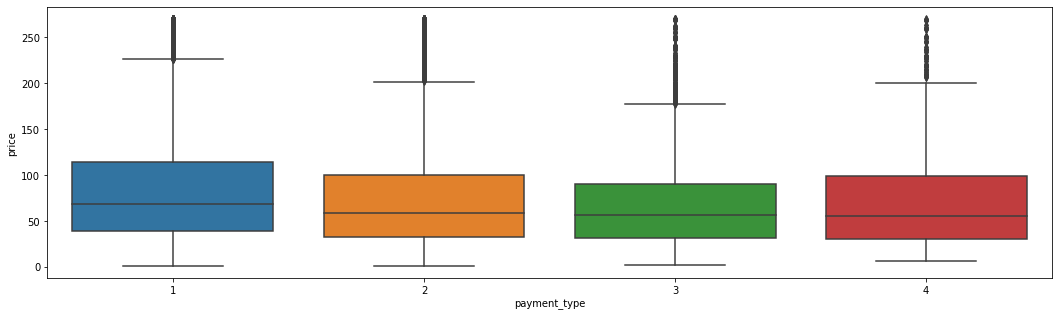

In [612]:
plt.figure(figsize=[18,5])
sns.boxplot(df1['payment_type'],df1['price'])
plt.show()

- **As we can see from the above boxplot the median of price for the payment_type 1 is the highest and the median of the other three payment modes slightly falls at the same value.**

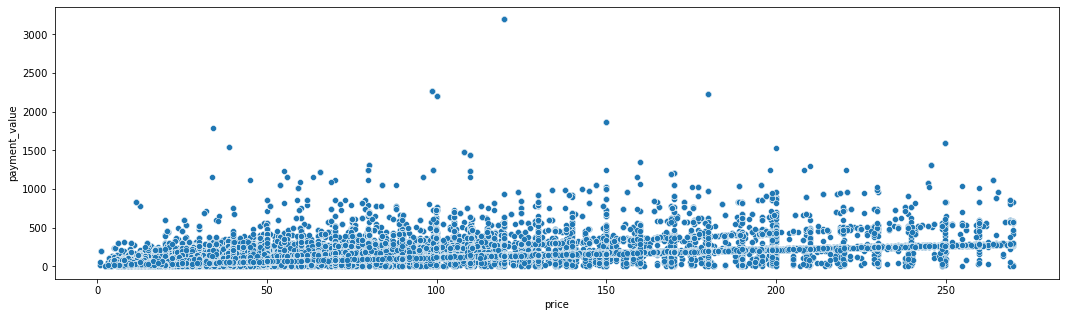

In [613]:
plt.figure(figsize=[18,5])
sns.scatterplot(df1['price'],df1['payment_value'])
plt.show()

- **As we can see from the above scatterplot there is a slight increase in the payment value when there is a increase in price.**

## *Statistical tests of Hypothesis.*

### Anova test (Payment_type Vs Price)

In [614]:
df_payment_type_1 = df[df['payment_type']==1]['price']
df_payment_type_2 = df[df['payment_type']==2]['price']
df_payment_type_3 = df[df['payment_type']==3]['price']
df_payment_type_4 = df[df['payment_type']==4]['price']

In [615]:
from scipy import stats
f_test, p_val = stats.f_oneway(df_payment_type_1,df_payment_type_2,df_payment_type_3,df_payment_type_4)
print('Test statistic:', f_test)
print('p-value:', p_val)      

Test statistic: 184.75471132974405
p-value: 1.7556669211812324e-119


- The p-value of the Anova test is lesser than 0.05.
- Hence we reject null hypothesis and accept alternative hypotheis.
- **The feature payment type is significant and impacting the target feature Price.**

### Two sample t-test, (freight_value Vs Price)

The null and alternative hypothesis is:

H<sub>0</sub>: $\mu_{1} - \mu_{2} = 0$<br>
H<sub>1</sub>: $\mu_{1} - \mu_{2} \neq 0$

In [616]:
from scipy.stats import ttest_ind
ttest_ind(df['freight_value'],df['price'])

Ttest_indResult(statistic=-453.1857295015249, pvalue=0.0)

## *`INFERENCE`*

- The p-value of the two sample t-test is lesser than 0.05.
- Hence we reject null hypothesis and accept alternative hypotheis.
- **The feature freight value is significant and impacting the target feature Price.**

### Two sample t-test, (Payment_value Vs Price)

The null and alternative hypothesis is:

H<sub>0</sub>: $\mu_{1} - \mu_{2} = 0$<br>
H<sub>1</sub>: $\mu_{1} - \mu_{2} \neq 0$

In [617]:
from scipy.stats import ttest_ind
ttest_ind(df['payment_value'],df['price'])

Ttest_indResult(statistic=-453.1857295015249, pvalue=0.0)

## *`INFERENCE`*

- The p-value of the two sample t-test is lesser than 0.05.
- Hence we reject null hypothesis and accept alternative hypotheis.
- **The feature payment value is significant and impacting the target feature Price.**

### Two sample t-test, (Payment_sequential Vs Price)

The null and alternative hypothesis is:

H<sub>0</sub>: $\mu_{1} - \mu_{2} = 0$<br>
H<sub>1</sub>: $\mu_{1} - \mu_{2} \neq 0$

In [618]:
from scipy.stats import ttest_ind
ttest_ind(df['payment_sequential'],df['price'])

Ttest_indResult(statistic=-453.02199206260565, pvalue=0.0)

## *`INFERENCE`*

- The p-value of the two sample t-test is lesser than 0.05.
- Hence we reject null hypothesis and accept alternative hypotheis.
- **The feature payment value is significant and impacting the target feature Price.**

## *Lets label Encode the feature payment_type.*

In [619]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [620]:
df['payment_type'] = le.fit_transform(df['payment_type'])

## *Splitting the dataset into train and test.*

In [621]:
X = df.drop('price',axis=1)
y = df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [622]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70934, 6)
(70934,)
(30401, 6)
(30401,)


## *Scaling the data.*

In [623]:
ss = StandardScaler()

In [624]:
X_train.iloc[:,[0,2,4]] = ss.fit_transform(X_train.iloc[:,[0,2,4]])
X_test.iloc[:,[0,2,4]] = ss.transform(X_test.iloc[:,[0,2,4]])

In [625]:
X_train.head(2)

,order_item_id,freight_value,payment_sequential,payment_type,payment_installments,payment_value
17651,-0.359166,0.068686,-0.186676,0,-0.664165,-0.325159
3027,-0.359166,1.910668,-0.186676,0,2.907832,0.724165


In [626]:
X_test.head(2)

,order_item_id,freight_value,payment_sequential,payment_type,payment_installments,payment_value
31912,-0.359166,2.231316,-0.186676,0,2.114055,0.590878
3946,-0.359166,-1.474786,-0.186676,0,-0.664165,-1.572260


## *Model Building*

## *Cross Validation models.*

In [627]:
from sklearn.model_selection import cross_validate

In [735]:
lr = LinearRegression()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
lr_model = cross_validate(lr,X,y,cv=kfold,scoring=scores)

print('Linear regression model r2-score:',lr_model['test_r2'].mean())
print('Linear regression model mean absolute error:',np.mean(np.abs(lr_model['test_neg_mean_absolute_error'])))
print('Linear regression model root mean squared error:',np.mean(np.sqrt(np.abs(lr_model['test_neg_mean_squared_error']))))

Linear regression model r2-score: 0.4352386542186041
Linear regression model mean absolute error: 30.612738844877377
Linear regression model root mean squared error: 42.10823081196186


In [736]:
dt = DecisionTreeRegressor()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
dt_model = cross_validate(dt,X,y,cv=kfold,scoring=scores)

print('Decision tree model r2-score:',dt_model['test_r2'].mean())
print('Decision tree model mean absolute error:',np.mean(np.abs(dt_model['test_neg_mean_absolute_error'])))
print('Decision tree model root mean squared error:',np.mean(np.sqrt(np.abs(dt_model['test_neg_mean_squared_error']))))

Decision tree model r2-score: 0.6938857501609939
Decision tree model mean absolute error: 11.042260807200027
Decision tree model root mean squared error: 31.011384821670937


In [737]:
rf = RandomForestRegressor()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
rf_model = cross_validate(rf,X,y,cv=kfold,scoring=scores)

print('Random Forest model r2-score:',rf_model['test_r2'].mean())
print('Random Forest model mean absolute error:',np.mean(np.abs(rf_model['test_neg_mean_absolute_error'])))
print('Random Forest model root mean squared error:',np.mean(np.sqrt(np.abs(rf_model['test_neg_mean_squared_error']))))

Random Forest model r2-score: 0.8182806388061767
Random Forest model mean absolute error: 10.353852131602341
Random Forest model root mean squared error: 23.89307995215828


In [458]:
knn = KNeighborsRegressor()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
knn_model = cross_validate(knn,X,y,cv=kfold,scoring=scores)

print('KNN model r2-score:',knn_model['test_r2'].mean())
print('KNN model mean absolute error:',np.mean(np.abs(knn_model['test_neg_mean_absolute_error'])))
print('KNN model root mean squared error:',np.mean(np.sqrt(np.abs(knn_model['test_neg_mean_squared_error']))))

KNN model r2-score: 0.7452324476614505
KNN model mean absolute error: 13.55320378941136
KNN model root mean squared error: 28.28813294285293


In [463]:
ada = AdaBoostRegressor()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
ada_model = cross_validate(ada,X,y,cv=kfold,scoring=scores)

print('Adaboost model model r2-score:',ada_model['test_r2'].mean())
print('Adaboost model mean absolute error:',np.mean(np.abs(ada_model['test_neg_mean_absolute_error'])))
print('Adaboost model root mean squared error:',np.mean(np.sqrt(np.abs(ada_model['test_neg_mean_squared_error']))))

Adaboost model model r2-score: 0.6098829481316018
Adaboost model mean absolute error: 26.406016591831825
Adaboost model root mean squared error: 34.98263550032944


In [462]:
gb = GradientBoostingRegressor()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
gb_model = cross_validate(gb,X,y,cv=kfold,scoring=scores)

print('Gradient boost model model r2-score:',gb_model['test_r2'].mean())
print('Gradient boost model mean absolute error:',np.mean(np.abs(gb_model['test_neg_mean_absolute_error'])))
print('Gradient model root mean squared error:',np.mean(np.sqrt(np.abs(gb_model['test_neg_mean_squared_error']))))

Gradient boost model model r2-score: 0.7668767885811213
Gradient boost model mean absolute error: 15.28571386945202
Gradient model root mean squared error: 27.060390421872455


In [733]:
xgb = XGBRegressor()
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
xgb_model = cross_validate(xgb,X,y,cv=kfold,scoring=scores)

print('Xtreme Gradient boost model model r2-score:',xgb_model['test_r2'].mean())
print('Xtreme Gradient boost model absolute error:',np.mean(np.abs(xgb_model['test_neg_mean_absolute_error'])))
print('Xtreme Gradient model root mean squared error:',np.mean(np.sqrt(np.abs(xgb_model['test_neg_mean_squared_error']))))

Xtreme Gradient boost model model r2-score: 0.8163463362704366
Xtreme Gradient boost model absolute error: 12.338000439797622
Xtreme Gradient model root mean squared error: 24.018409748230244


In [464]:
rf = RandomForestRegressor()
rf_boost = AdaBoostRegressor(base_estimator=rf)
kfold = KFold(shuffle=True,n_splits=5,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
rf_boost_model = cross_validate(rf_boost,X,y,cv=kfold,scoring=scores)

print('Boosted RF model model r2-score:',rf_boost_model['test_r2'].mean())
print('Boosted RF model mean absolute error:',np.mean(np.abs(rf_boost_model['test_neg_mean_absolute_error'])))
print('Boosted RF model root mean squared error:',np.mean(np.sqrt(np.abs(rf_boost_model['test_neg_mean_squared_error']))))

Boosted RF model model r2-score: 0.8179696996016993
Boosted RF model mean absolute error: 12.763432064515152
Boosted RF model root mean squared error: 23.91335987352443


## *Comparison of results of the models built.*

In [738]:
print('Linear regression model r2-score:',lr_model['test_r2'].mean())
print('Linear regression model mean absolute error:',np.mean(np.abs(lr_model['test_neg_mean_absolute_error'])))
print('Linear regression model root mean squared error:',np.mean(np.sqrt(np.abs(lr_model['test_neg_mean_squared_error']))))
print('~'*100)
print('Decision tree model r2-score:',dt_model['test_r2'].mean())
print('Decision tree model mean absolute error:',np.mean(np.abs(dt_model['test_neg_mean_absolute_error'])))
print('Decision tree model root mean squared error:',np.mean(np.sqrt(np.abs(dt_model['test_neg_mean_squared_error']))))
print('~'*100)
print('\033[1;46;13m Random Forest model r2-score:\033[0;0m',rf_model['test_r2'].mean())
print('\033[1;46;13m Random Forest model mean absolute error:\033[0;0m',np.mean(np.abs(rf_model['test_neg_mean_absolute_error'])))
print('\033[1;46;13m Random Forest model root mean squared error:\033[0;0m',np.mean(np.sqrt(np.abs(rf_model['test_neg_mean_squared_error']))))
print('~'*100)
print('KNN model r2-score:',knn_model['test_r2'].mean())
print('KNN model mean absolute error:',np.mean(np.abs(knn_model['test_neg_mean_absolute_error'])))
print('KNN model root mean squared error:',np.mean(np.sqrt(np.abs(knn_model['test_neg_mean_squared_error']))))
print('~'*100)
print('Adaboost model model r2-score:',ada_model['test_r2'].mean())
print('Adaboost model mean absolute error:',np.mean(np.abs(ada_model['test_neg_mean_absolute_error'])))
print('Adaboost model root mean squared error:',np.mean(np.sqrt(np.abs(ada_model['test_neg_mean_squared_error']))))
print('~'*100)
print('Gradient boost model model r2-score:',gb_model['test_r2'].mean())
print('Gradient boost model mean absolute error:',np.mean(np.abs(gb_model['test_neg_mean_absolute_error'])))
print('Gradient model root mean squared error:',np.mean(np.sqrt(np.abs(gb_model['test_neg_mean_squared_error']))))
print('~'*100)
print('\033[1;46;13m Xtreme Gradient boost model model r2-score:\033[0;0m',xgb_model['test_r2'].mean())
print('\033[1;46;13m Xtreme Gradient boost model mean absolute error:\033[0;0m',np.mean(np.abs(xgb_model['test_neg_mean_absolute_error'])))
print('\033[1;46;13m Xtreme Gradient model root mean squared error:\033[0;0m',np.mean(np.sqrt(np.abs(xgb_model['test_neg_mean_squared_error']))))
print('~'*100)
print('Boosted RF model model r2-score:',rf_boost_model['test_r2'].mean())
print('Boosted RF model mean absolute error:',np.mean(np.abs(rf_boost_model['test_neg_mean_absolute_error'])))
print('Boosted RF model root mean squared error:',np.mean(np.sqrt(np.abs(rf_boost_model['test_neg_mean_squared_error']))))
print('~'*100)

Linear regression model r2-score: 0.4352386542186041
Linear regression model mean absolute error: 30.612738844877377
Linear regression model root mean squared error: 42.10823081196186
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Decision tree model r2-score: 0.6938857501609939
Decision tree model mean absolute error: 11.042260807200027
Decision tree model root mean squared error: 31.011384821670937
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Random Forest model r2-score: 0.8182806388061767
 Random Forest model mean absolute error: 10.353852131602341
 Random Forest model root mean squared error: 23.89307995215828
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNN model r2-score: 0.7452324476614505
KNN model mean absolute error: 13.55320378941136
KNN model root mean squared error: 28.28813294285293
~~~~~~~~~~~~~~~~~~~~~~~~

## *The highlighted two models are performing good with highest r2-score and the least mean absolute error and root mean squared error among all the other models.*

## *Hyperparameter Tuning*

In [526]:
rf = RandomForestRegressor(random_state=0)
params = [{'n_estimators':[10,30,50,70,90],
            'max_depth':[10,15,20],
            'min_samples_split':[2,5,8,11],
            'min_samples_leaf':[1,5,9]}]
gsearch_rf = GridSearchCV(estimator=rf, param_grid=params, cv=3, scoring='r2')
gsearch_rf.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid=[{'max_depth': [10, 15, 20],
                          'min_samples_leaf': [1, 5, 9],
                          'min_samples_split': [2, 5, 8, 11],
                          'n_estimators': [10, 30, 50, 70, 90]}],
             scoring='r2')

In [527]:
gsearch_rf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 90}

## *From Hyperparameter tuning we got n_estimators as 90, min_samples_leaf as 1, min samples split as 5 & max depth as 5, lets build the model using the best hyperparameter obtained from gridsearch.*

In [528]:
rf = RandomForestRegressor(n_estimators=90,max_depth=20,min_samples_leaf=1,min_samples_split=5)
kfold = KFold(shuffle=True,n_splits=3,random_state=0)
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
rf_model = cross_validate(rf,X,y,cv=kfold,scoring=scores)

print('Random Forest model r2-score:',rf_model['test_r2'].mean())
print('Random Forest model mean absolute error:',np.mean(np.abs(rf_model['test_neg_mean_absolute_error'])))
print('Random Forest model root mean squared error:',np.mean(np.sqrt(np.abs(rf_model['test_neg_mean_squared_error']))))

Random Forest model r2-score: 0.8119027323826833
Random Forest model mean absolute error: 11.157040174193037
Random Forest model root mean squared error: 24.310588749360225


## *After Hyperparameter tuning also there is no significant change in the results, So lets consider Random Forest Regressor model as the best performing model compare to other models.*

## *Comparison of results of base model Vs Final model.*

In [739]:
print('\033[1;46;13m Base model:- \033[0;0m')
print('Linear regression model r2-score:',lr_model['test_r2'].mean())
print('Linear regression model mean absolute error:',np.mean(np.abs(lr_model['test_neg_mean_absolute_error'])))
print('Linear regression model root mean squared error:',np.mean(np.sqrt(np.abs(lr_model['test_neg_mean_squared_error']))))
print('~'*100)
print('\033[1;46;13m Final model:- \033[0;0m')
print('Random Forest model r2-score:',rf_model['test_r2'].mean())
print('Random Forest model mean absolute error:',np.mean(np.abs(rf_model['test_neg_mean_absolute_error'])))
print('Random Forest model root mean squared error:',np.mean(np.sqrt(np.abs(rf_model['test_neg_mean_squared_error']))))

 Base model:- 
Linear regression model r2-score: 0.4352386542186041
Linear regression model mean absolute error: 30.612738844877377
Linear regression model root mean squared error: 42.10823081196186
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Final model:- 
Random Forest model r2-score: 0.8182806388061767
Random Forest model mean absolute error: 10.353852131602341
Random Forest model root mean squared error: 23.89307995215828


## *`We Choose Random Forest Regressor model as the Final model.`*
- **We can see that the r2-score for base model is 0.43 and RMSE is 42.10.**
- **For the final model the r2-score is 0.81 and RMSE is 23.89.**
- **from base model to final model, we can see an significant increase in the r2-score by minimizing the rmse.**

## *Pickling - Creating a pickle file with an extension as .pkl*

In [722]:
# Saving model to disk
pickle.dump(rf, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))

In [776]:
model.predict([[1,20,1,2,2,100]])

array([172.6509])